Graph loaded successfully from ../data/subway_graph_weekday_weekend.gml
Number of nodes: 395
Number of edges: 708


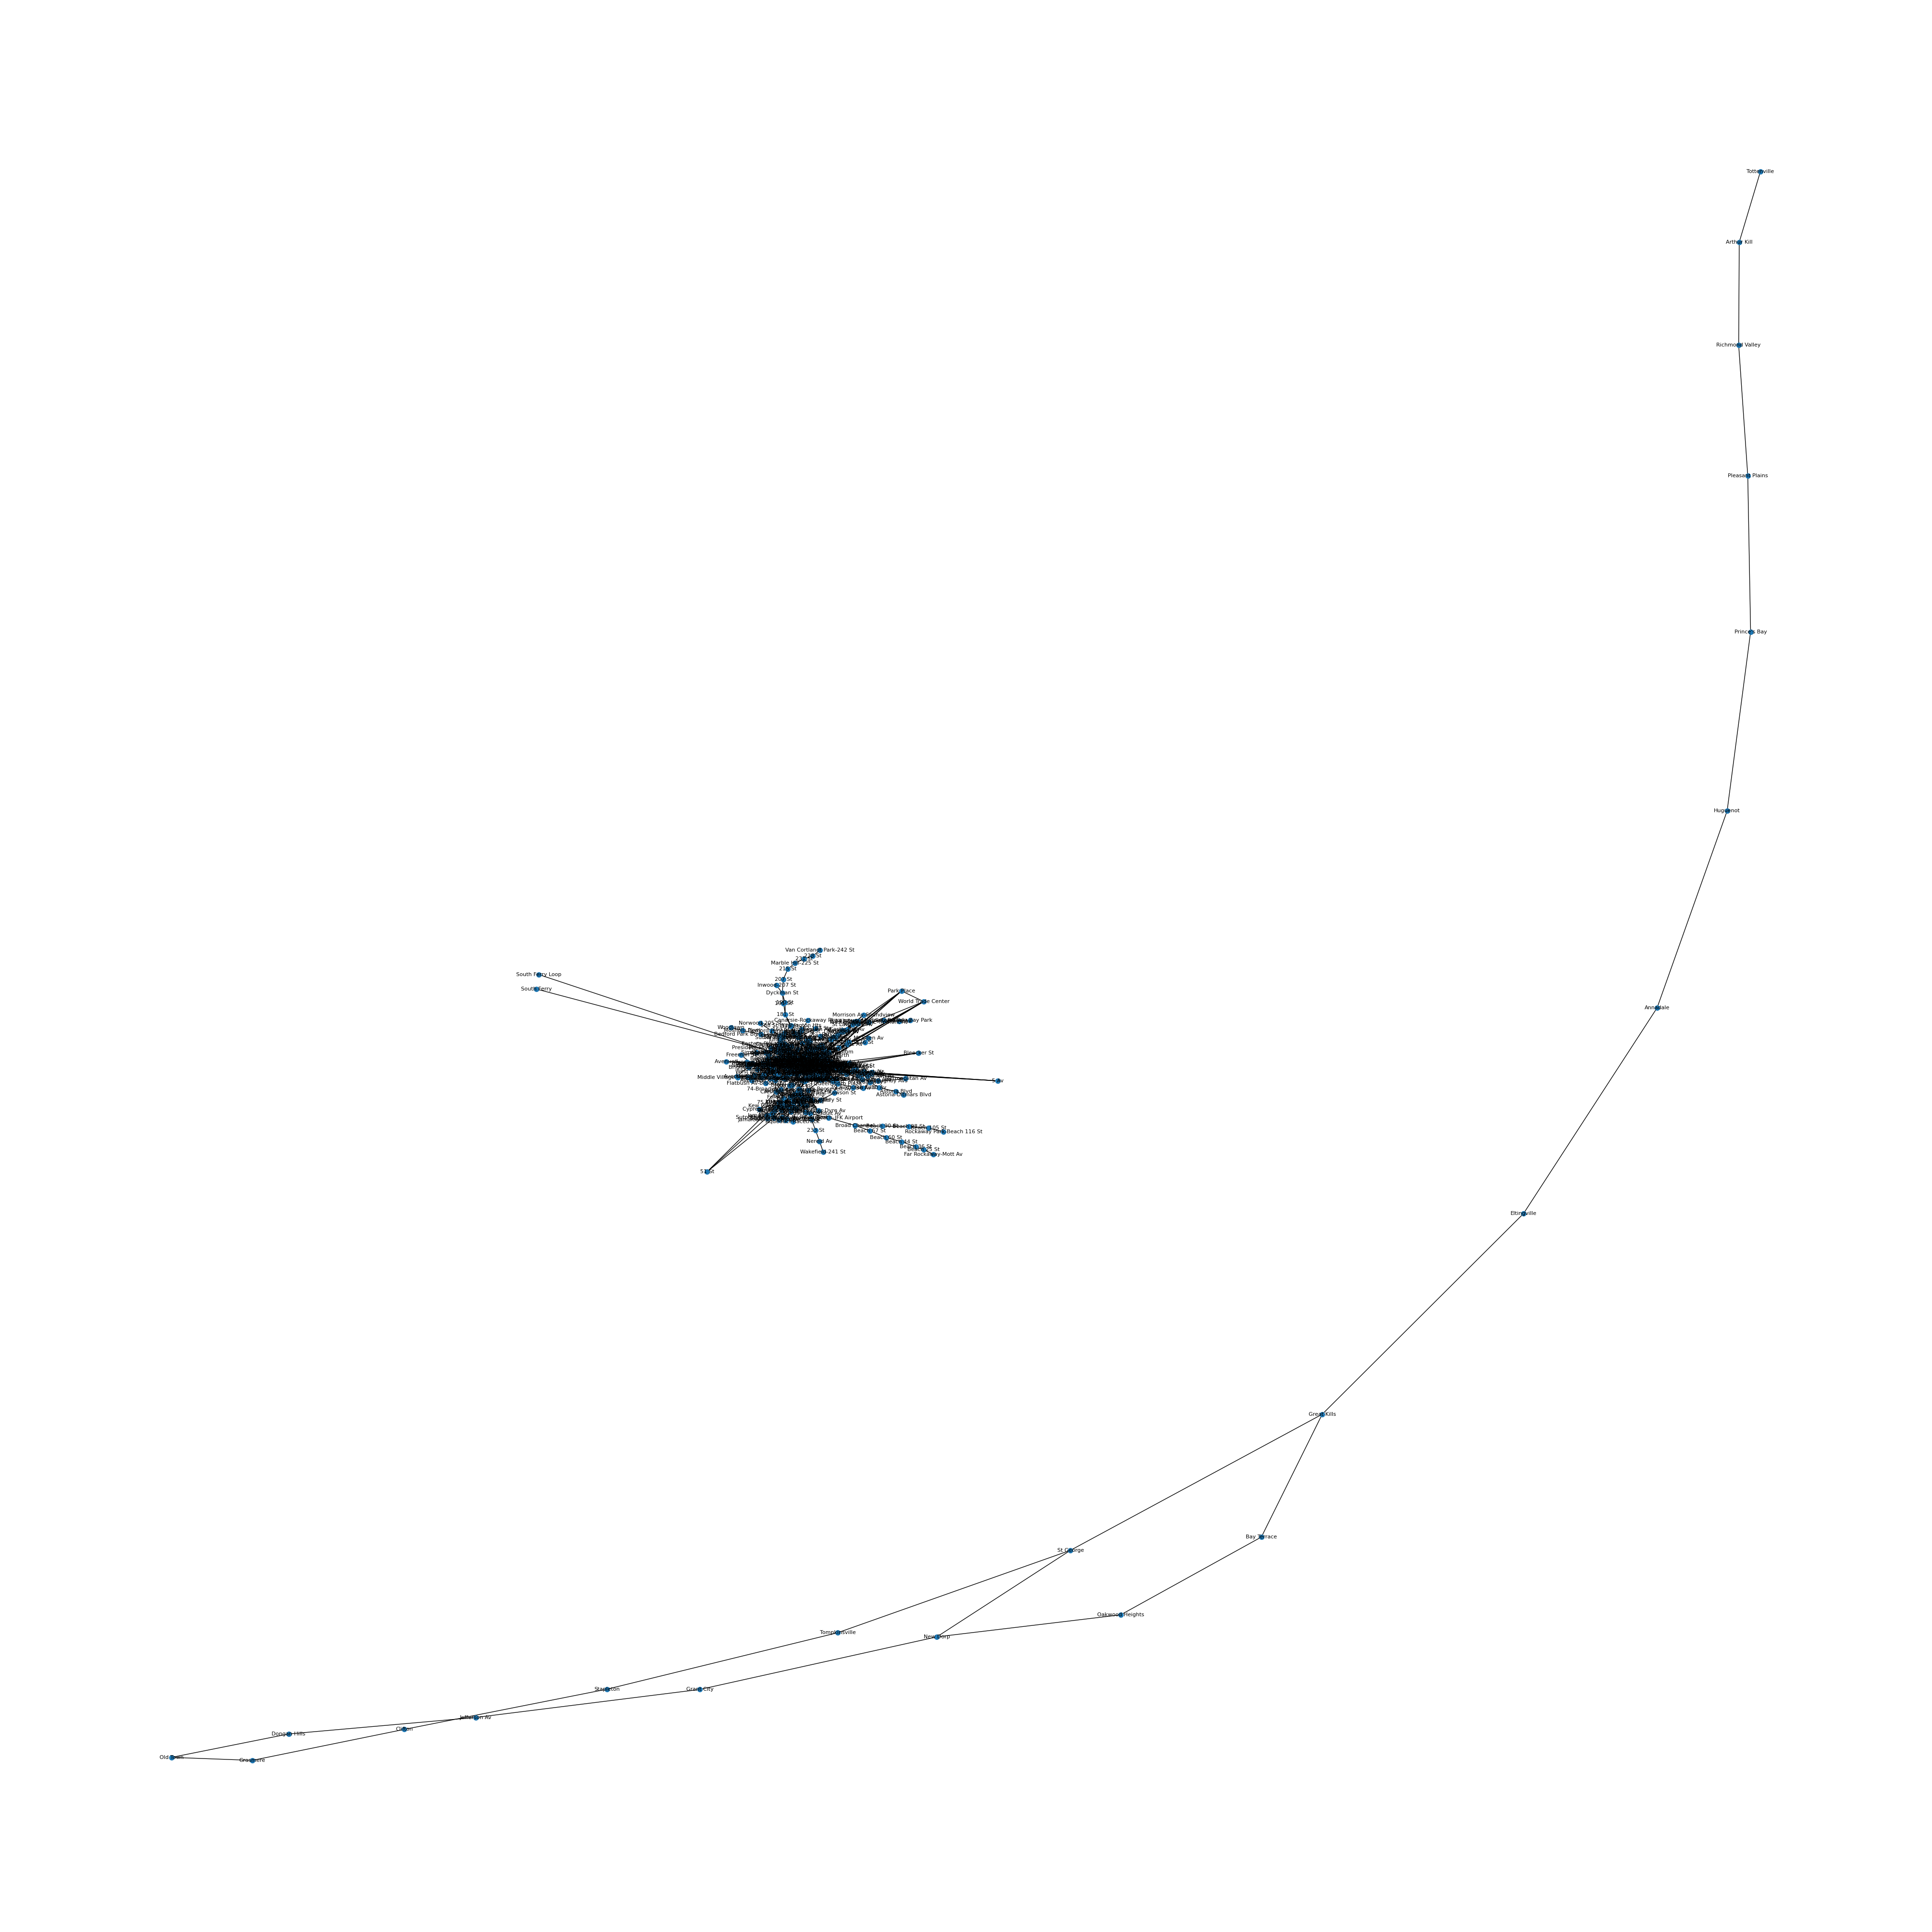

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

# Load the GML file
file_path = '../data/subway_graph_weekday_weekend.gml'
G = nx.read_gml(file_path)

# Display basic information about the graph
print(f"Graph loaded successfully from {file_path}")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

# Optional: Draw the graph (might be slow for large graphs)
plt.figure(figsize=(40, 40))
nx.draw(G, with_labels=True, node_size=50, font_size=8)

plt.savefig('subway_network_weekday_weekend.png', dpi=300)

plt.show()


In [24]:
import networkx as nx
import matplotlib.pyplot as plt

# Load the GML file
file_path = '../data/subway_graph_weekday_weekend.gml'
G_weights = nx.read_gml(file_path)

# Display basic information about the graph
print(f"Graph loaded successfully from {file_path}")
print(f"Number of nodes: {G_weights.number_of_nodes()}")
print(f"Number of edges: {G_weights.number_of_edges()}")

# Optional: Draw the graph (might be slow for large graphs)
# plt.figure(figsize=(12, 12))
# nx.draw(G, with_labels=True, node_size=50, font_size=8)
# plt.show()

Graph loaded successfully from ../data/subway_graph_weekday_weekend.gml
Number of nodes: 395
Number of edges: 708


In [10]:
import networkx as nx
import matplotlib.pyplot as plt

# Load the GML file
file_path = '../citibike_weekday_network.gml'
G_weights = nx.read_gml(file_path)
G_weights = G_weights.to_undirected()

# Display basic information about the graph
print(f"Graph loaded successfully from {file_path}")
print(f"Number of nodes: {G_weights.number_of_nodes()}")
print(f"Number of edges: {G_weights.number_of_edges()}")

Graph loaded successfully from ../citibike_weekday_network.gml
Number of nodes: 2189
Number of edges: 351005


## Calculate PD

In [9]:
import pandas as pd
import networkx as nx

def calculate_PD(G, num_hops):
    """
    Calculates the normalized number of reachable nodes (Proximity Density) for each
    component of the graph separately.

    Args:
        G (nx.Graph): The input graph.
        num_hops (int): The maximum number of hops to consider.

    Returns:
        list: A list of pandas DataFrames, where each DataFrame contains the PD
              results for one connected component.
    """
    results_list = []

    # Sort components by size (largest first) for consistent ordering
    components = sorted(nx.connected_components(G), key=len, reverse=True)

    # Iterate over each connected component in the graph
    for component in components:
        component_graph = G.subgraph(component).copy()
        total_nodes_in_component = component_graph.number_of_nodes()
        
        proximity_density = {}

        # Iterate over each node within the current component
        for node in component_graph.nodes():
            distances = nx.single_source_shortest_path_length(component_graph, node, cutoff=num_hops)
            count = len(distances) - 1
            
            if total_nodes_in_component > 1:
                pd_value = count / (total_nodes_in_component - 1)
            else:
                pd_value = 0
            
            proximity_density[node] = pd_value

        # Create a pandas Series for the current component's results
        pd_series = pd.Series(proximity_density, name=f"PD_within_{num_hops}_hops")
        
        # Convert to DataFrame, sort, and add to the list
        component_df = pd_series.to_frame()
        component_df = component_df.sort_values(by=f"PD_within_{num_hops}_hops", ascending=False)
        results_list.append(component_df)

    return results_list

In [26]:
# --- Example Usage of the Function ---
# Define the number of hops for the analysis
hop_count = 5

# Call the function with the weighted graph and the desired hop count
# This will return a list of DataFrames, one for each component
component_pd_results = calculate_PD(G_weights, hop_count)

# Display the results for each component
for i, df in enumerate(component_pd_results):
    print(f"--- Proximity Density (PD) for Component {i+1} ({len(df)} nodes) ---")
    print(f"Analysis based on a hop limit of {hop_count} stops:")
    print(df.head(10))  # Displaying the top 10 for brevity
    print("\n")


--- Proximity Density (PD) for Component 1 (374 nodes) ---
Analysis based on a hop limit of 5 stops:
                          PD_within_5_hops
Atlantic Av-Barclays Ctr          0.689008
36 St                             0.686327
7 Av                              0.672922
59 St                             0.667560
Prospect Park                     0.643432
59 St-Columbus Circle             0.635389
125 St                            0.619303
86 St                             0.619303
14 St-8 Av                        0.616622
Jay St-MetroTech                  0.605898


--- Proximity Density (PD) for Component 2 (21 nodes) ---
Analysis based on a hop limit of 5 stops:
                 PD_within_5_hops
Great Kills                  0.80
St George                    0.80
New Dorp                     0.75
Tompkinsville                0.75
Eltingville                  0.75
Stapleton                    0.70
Grant City                   0.70
Oakwood Heights              0.70
Annadale          

## Calculate PAD

In [14]:
import pandas as pd
import networkx as nx

def calculate_average_hops_to_all_nodes(G):
    """
    Calculates the average number of hops from each node to all other reachable
    nodes within its connected component.

    Args:
        G (nx.Graph): The input graph.

    Returns:
        list: A list of pandas DataFrames, where each DataFrame contains the
              average hop results for one connected component.
    """
    results_list = []

    # Sort components by size (largest first) for consistent ordering
    components = sorted(nx.connected_components(G), key=len, reverse=True)

    # Iterate over each connected component in the graph
    for component in components:
        component_graph = G.subgraph(component).copy()
        avg_hops = {}

        # Iterate over each node within the current component
        for node in component_graph.nodes():
            # Calculate shortest path lengths (number of hops) to all other nodes
            distances = nx.single_source_shortest_path_length(component_graph, node)
            
            # Calculate the average of these distances (excluding the node itself)
            if len(distances) > 1:
                # Sum of distances to all other nodes
                total_hops = sum(distances.values())
                # Number of other nodes
                num_other_nodes = len(distances) - 1
                avg_hops[node] = total_hops / num_other_nodes
            else:
                avg_hops[node] = 0

        # Create a pandas Series for the current component's results
        avg_hops_series = pd.Series(avg_hops, name="Average_Hops_to_All_Nodes")
        
        # Convert to DataFrame, sort, and add to the list
        component_df = avg_hops_series.to_frame()
        component_df = component_df.sort_values(by="Average_Hops_to_All_Nodes", ascending=True) # Lower is better
        results_list.append(component_df)

    return results_list

In [27]:
# --- Example Usage of the Average Hops Function ---
# Call the function with the weighted graph
# Note: The function ignores weights and calculates hops
component_avg_hops_results = calculate_average_hops_to_all_nodes(G_weights)

# Display the results for each component
for i, df in enumerate(component_avg_hops_results):
    print(f"--- Average Hops to All Nodes for Component {i+1} ({len(df)} nodes) ---")
    print(df.head(10))  # Displaying the top 10 for brevity
    print("\n")


--- Average Hops to All Nodes for Component 1 (374 nodes) ---
                          Average_Hops_to_All_Nodes
Atlantic Av-Barclays Ctr                   4.914209
36 St                                      4.941019
59 St                                      4.959786
7 Av                                       5.013405
14 St-8 Av                                 5.254692
59 St-Columbus Circle                      5.273458
86 St                                      5.289544
Prospect Park                              5.292225
DeKalb Av                                  5.442359
125 St                                     5.453083


--- Average Hops to All Nodes for Component 2 (21 nodes) ---
                 Average_Hops_to_All_Nodes
Great Kills                           3.70
St George                             3.70
Eltingville                           3.95
New Dorp                              4.10
Tompkinsville                         4.25
Annadale                              4.30
Ba

## Measure Robustness

## Measure Robustness by Reachability


In [16]:
import pandas as pd
import networkx as nx
from tqdm import tqdm

def analyze_robustness_by_reachability(G):
    """
    Analyzes network robustness for each component by removing each node and
    counting the number of nodes that become unreachable from the main cluster.

    Args:
        G (nx.Graph): The input graph.

    Returns:
        list: A list of pandas DataFrames, one for each component, showing the
              impact of removing each node.
    """
    results_list = []
    
    components = sorted(nx.connected_components(G), key=len, reverse=True)

    for i, component_nodes in enumerate(components):
        component_graph = G.subgraph(component_nodes).copy()
        num_nodes_in_component = component_graph.number_of_nodes()
        
        print(f"\n--- Analyzing Component {i+1} with {num_nodes_in_component} nodes ---")

        if num_nodes_in_component <= 1:
            print("Component is too small to analyze. Skipping.")
            continue

        reachability_results = []

        for node_to_remove in tqdm(component_graph.nodes(), desc=f"Analyzing Component {i+1}"):
            G_temp = component_graph.copy()
            G_temp.remove_node(node_to_remove)

            if not G_temp.nodes():
                nodes_unreachable = 0
            else:
                # Find the size of the largest component after removal
                largest_remaining_comp = max(nx.connected_components(G_temp), key=len)
                size_of_largest_remaining = len(largest_remaining_comp)
                
                # Unreachable nodes are those not in the largest remaining component
                nodes_unreachable = (num_nodes_in_component - 1) - size_of_largest_remaining

            reachability_results.append({
                'Removed_Node': node_to_remove,
                'Nodes_Made_Unreachable': nodes_unreachable
            })

        results_df = pd.DataFrame(reachability_results)
        results_df = results_df.sort_values(by='Nodes_Made_Unreachable', ascending=False)
        results_list.append(results_df)
        
    return results_list

In [28]:
# --- Example Usage of the Reachability Robustness Function ---
# Call the function with the weighted graph
# Note: The function ignores weights and calculates hops
component_reachability_results = analyze_robustness_by_reachability(G_weights)

# Display the top critical nodes for each component
for i, df in enumerate(component_reachability_results):
    print(f"\n--- Top 10 Most Critical Nodes for Component {i+1} (by reachability) ---")
    print(df.head(10))



--- Analyzing Component 1 with 374 nodes ---


Analyzing Component 1: 100%|██████████| 374/374 [00:00<00:00, 432.04it/s]



--- Analyzing Component 2 with 21 nodes ---


Analyzing Component 2: 100%|██████████| 21/21 [00:00<00:00, 10478.28it/s]


--- Top 10 Most Critical Nodes for Component 1 (by reachability) ---
                 Removed_Node  Nodes_Made_Unreachable
13                     125 St                      18
136               3 Av-138 St                      17
181             Rockaway Blvd                      14
47                   E 180 St                      13
182     Aqueduct-N Conduit Av                      12
183  Howard Beach-JFK Airport                      11
130            Hunts Point Av                      11
184             Broad Channel                      10
8                      181 St                      10
42                Gun Hill Rd                       7

--- Top 10 Most Critical Nodes for Component 2 (by reachability) ---
       Removed_Node  Nodes_Made_Unreachable
10      Great Kills                       8
0       Eltingville                       7
14         Annadale                       6
12         Huguenot                       5
4      Prince's Bay                       4
11

## Measure Robustness by Global Efficiency


In [18]:
import pandas as pd
import networkx as nx
from tqdm import tqdm
import itertools

def analyze_robustness_by_global_efficiency(G):
    """
    Analyzes network robustness by removing each node and measuring the
    percentage decrease in the network's global efficiency.

    Args:
        G (nx.Graph): The input graph.

    Returns:
        pd.DataFrame: A DataFrame with nodes sorted by their impact on
                      global efficiency when removed.
    """
    
    def calculate_global_efficiency(graph):
        """Helper function to calculate global efficiency based on the user's formula."""
        n = graph.number_of_nodes()
        if n < 2:
            return 0.0
        
        total_efficiency = 0
        # Calculate shortest path lengths for all pairs in the graph
        # This handles disconnected components correctly by iterating through them.
        for component in nx.connected_components(graph):
            subgraph = graph.subgraph(component)
            path_lengths = dict(nx.all_pairs_shortest_path_length(subgraph))
            
            for source, targets in path_lengths.items():
                for target, distance in targets.items():
                    if distance > 0:
                        total_efficiency += 1 / distance
        
        # The formula sums over all pairs, so we divide by N*(N-1)
        return total_efficiency / (n * (n - 1))

    # --- 1. Calculate the baseline global efficiency of the entire network ---
    initial_efficiency = calculate_global_efficiency(G)
    print(f"Initial Global Efficiency of the network: {initial_efficiency:.4f}")

    robustness_results = []

    # --- 2. Iterate through each node, remove it, and measure the impact ---
    for node_to_remove in tqdm(G.nodes(), desc="Analyzing node removals for efficiency"):
        G_temp = G.copy()
        G_temp.remove_node(node_to_remove)

        new_efficiency = calculate_global_efficiency(G_temp)
        
        if initial_efficiency > 0:
            decrease_percent = ((initial_efficiency - new_efficiency) / initial_efficiency) * 100
        else:
            decrease_percent = 0

        robustness_results.append({
            'Removed_Node': node_to_remove,
            'New_Global_Efficiency': new_efficiency,
            'Efficiency_Decrease_Percent': decrease_percent
        })

    # --- 3. Create and sort the results DataFrame ---
    results_df = pd.DataFrame(robustness_results)
    results_df = results_df.sort_values(by='Efficiency_Decrease_Percent', ascending=False)
    
    return results_df

In [29]:
# --- Example Usage of the Global Efficiency Robustness Function ---
# Call the function with the full graph
# Note: The function ignores weights and calculates hops
global_efficiency_results_df = analyze_robustness_by_global_efficiency(G_weights)

# Display the top 15 most critical nodes
print("\n--- Top 15 Most Critical Nodes (by impact on Global Efficiency) ---")
print(global_efficiency_results_df.head(15))


Initial Global Efficiency of the network: 0.1528


Analyzing node removals for efficiency: 100%|██████████| 395/395 [03:36<00:00,  1.83it/s]


--- Top 15 Most Critical Nodes (by impact on Global Efficiency) ---
                 Removed_Node  New_Global_Efficiency  \
13                     125 St               0.135886   
136               3 Av-138 St               0.143762   
47                   E 180 St               0.146433   
130            Hunts Point Av               0.147131   
181             Rockaway Blvd               0.147914   
11                     145 St               0.148482   
18                      86 St               0.148728   
75                  Church Av               0.148758   
182     Aqueduct-N Conduit Av               0.149027   
8                      181 St               0.149036   
67   Atlantic Av-Barclays Ctr               0.149121   
103                     59 St               0.149124   
298        Myrtle-Wyckoff Avs               0.149226   
231                     36 St               0.149290   
183  Howard Beach-JFK Airport               0.149494   

     Efficiency_Decrease_Percent  

## Node Betweenness Centrality


In [20]:
import pandas as pd
import networkx as nx

def calculate_node_betweenness_centrality(G):
    """
    Calculates the node betweenness centrality for each node within its
    connected component.

    Args:
        G (nx.Graph): The input graph.

    Returns:
        list: A list of pandas DataFrames, one for each component, with nodes
              sorted by their betweenness centrality.
    """
    results_list = []
    components = sorted(nx.connected_components(G), key=len, reverse=True)

    for i, component_nodes in enumerate(components):
        component_graph = G.subgraph(component_nodes).copy()
        
        # NetworkX's function calculates centrality for the given graph.
        # If the graph is disconnected, it computes it for each component implicitly,
        # but we do it explicitly to get separate DataFrames.
        node_centrality = nx.betweenness_centrality(component_graph, normalized=True)
        
        centrality_series = pd.Series(node_centrality, name="Node_Betweenness_Centrality")
        
        component_df = centrality_series.to_frame()
        component_df = component_df.sort_values(by="Node_Betweenness_Centrality", ascending=False)
        results_list.append(component_df)
        
    return results_list

In [21]:
# --- Calculate and Display Node Betweenness Centrality ---
component_node_centrality = calculate_node_betweenness_centrality(G_weights)

for i, df in enumerate(component_node_centrality):
    print(f"\n--- Top 10 Nodes by Betweenness Centrality for Component {i+1} ---")
    print(df.head(10))



--- Top 10 Nodes by Betweenness Centrality for Component 1 ---
                                      Node_Betweenness_Centrality
125 St                                                   0.318211
36 St                                                    0.214964
59 St                                                    0.209868
Atlantic Av-Barclays Ctr                                 0.206347
86 St                                                    0.200005
7 Av                                                     0.183024
59 St-Columbus Circle                                    0.159175
145 St                                                   0.149144
74-Broadway-Jackson Hts-Roosevelt Av                     0.144742
Queens Plaza                                             0.136887

--- Top 10 Nodes by Betweenness Centrality for Component 2 ---
                 Node_Betweenness_Centrality
Great Kills                         0.531579
St George                           0.507895
Eltingville

## Edge Betweenness Centrality


In [22]:
import pandas as pd
import networkx as nx

def calculate_edge_betweenness_centrality(G):
    """
    Calculates the edge betweenness centrality for each edge within its
    connected component.

    Args:
        G (nx.Graph): The input graph.

    Returns:
        list: A list of pandas DataFrames, one for each component, with edges
              sorted by their betweenness centrality.
    """
    results_list = []
    components = sorted(nx.connected_components(G), key=len, reverse=True)

    for i, component_nodes in enumerate(components):
        component_graph = G.subgraph(component_nodes).copy()
        
        edge_centrality = nx.edge_betweenness_centrality(component_graph, normalized=True)
        
        # Format the results for better readability
        edge_centrality_series = pd.Series(edge_centrality)
        edge_centrality_series.index = pd.MultiIndex.from_tuples(
            edge_centrality_series.index, names=['Node_1', 'Node_2']
        )
        
        component_df = edge_centrality_series.to_frame(name="Edge_Betweenness_Centrality")
        component_df = component_df.sort_values(by="Edge_Betweenness_Centrality", ascending=False)
        results_list.append(component_df)
        
    return results_list

In [23]:
# --- Calculate and Display Edge Betweenness Centrality ---
component_edge_centrality = calculate_edge_betweenness_centrality(G_weights)

for i, df in enumerate(component_edge_centrality):
    print(f"\n--- Top 10 Edges by Betweenness Centrality for Component {i+1} ---")
    print(df.head(10))



--- Top 10 Edges by Betweenness Centrality for Component 1 ---
                                                               Edge_Betweenness_Centrality
Node_1                   Node_2                                                           
86 St                    59 St                                                    0.157488
125 St                   59 St-Columbus Circle                                    0.148062
                         86 St                                                    0.146528
145 St                   125 St                                                   0.143615
59 St-Columbus Circle    7 Av                                                     0.122667
Atlantic Av-Barclays Ctr 36 St                                                    0.105290
125 St                   3 Av-138 St                                              0.091870
Queens Plaza             74-Broadway-Jackson Hts-Roosevelt Av                     0.088619
36 St                    Q